In [1]:
# connect to google colab
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
# ​I confirm that this is my own work, except where clearly indicated.
# PCOVID19 Global Forecasting (Week 2)
# Author: 190000096
# Date: 25.04.2020

# general processing
import numpy as np
import pandas as pd

# data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno
import seaborn as sns

# categorical feature encoding
from sklearn.preprocessing import LabelEncoder

# model comparison
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

# fine tun the model
from sklearn.model_selection import GridSearchCV

# plot feature importance
from xgboost import plot_importance

# model assessment
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
# load data
train = pd.read_csv('/content/drive/My Drive/train12.csv')
test = pd.read_csv('/content/drive/My Drive/test12.csv')

In [0]:
# backup the test set
test1 = test

In [5]:
train.head(5)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [6]:
test.head(5)

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23


## **Add an external Dataset** ##





In [0]:
# read country infomation
country_stat = pd.read_csv('/content/drive/My Drive/covid19countryinfo.csv')
country_stat = country_stat[country_stat['region'].isnull()]

In [0]:
# add useful country features to the data set
# Reference: https://www.kaggle.com/resheto/covid-19-prediction-of-deltas-using-extended-data/output
def add_country_stat(old_df):
    df = old_df.copy()
    df = df.merge(country_stat[[
        'country', 'pop', 'medianage', 'sex65plus', 'lung', 'smokers',
        'density'
    ]],
                  left_on=['Country_Region'],
                  right_on=['country'],
                  how='left')
    df.drop(columns=['country'], inplace=True)
    df['pop'] = df['pop'].fillna(1000)
    df['pop'] = df['pop'].apply(lambda x: int(str(x).replace(',', '')))
    df['density'] = df['density'].fillna(0)
    df['medianage'] = df['medianage'].fillna(0)
    df['sex65plus'] = df['sex65plus'].fillna(1)
    df['lung'] = df['lung'].fillna(24)
    df['smokers'] = df['smokers'].fillna(24)

    return df

In [0]:
train = add_country_stat(train)
test = add_country_stat(test)

## **Data Visaulisation** ##

In [10]:
# have a general view of the data
print("Number of countries included in dataset:",
      train.Country_Region.nunique())
print("Date Range is from ", train.Date.min(), "to", train.Date.max())

Number of countries included in dataset: 173
Date Range is from  2020-01-22 to 2020-03-31


In [0]:
# plot daily world trend
total = train.groupby(['Date']).sum().reset_index(drop=False)
total = total[["Date", "ConfirmedCases", "Fatalities"]]

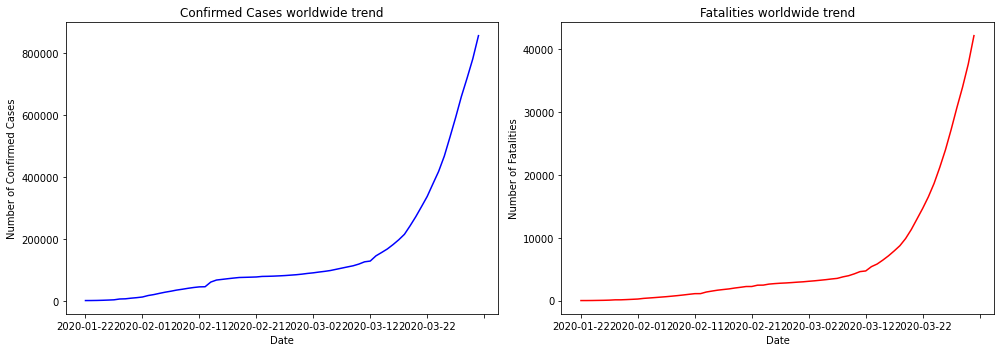

In [12]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
total.groupby('Date')['ConfirmedCases'].sum().plot(color='blue')
plt.ylabel('Number of Confirmed Cases')
plt.title('Confirmed Cases worldwide trend')

plt.subplot(1, 2, 2)
total.groupby('Date')['Fatalities'].sum().plot(color='red')
plt.ylabel('Number of Fatalities')
plt.title("Fatalities worldwide trend")
plt.tight_layout()

In [13]:
# plot the virus situation in different countries
train.loc[:, ['Country_Region', 'ConfirmedCases', 'Fatalities']].groupby(
    ['Country_Region']).max().sort_values(
        by='ConfirmedCases',
        ascending=False).reset_index()[:15].style.background_gradient(
            cmap='rainbow')

,Country_Region,ConfirmedCases,Fatalities
0,Italy,105792.000000,12428.000000
1,Spain,95923.000000,8464.000000
2,US,75833.000000,1550.000000
3,Germany,71808.000000,775.000000
4,China,67801.000000,3187.000000
5,France,52128.000000,3523.000000
6,Iran,44605.000000,2898.000000
7,United Kingdom,25150.000000,1789.000000
8,Switzerland,16605.000000,433.000000
9,Turkey,13531.000000,214.000000


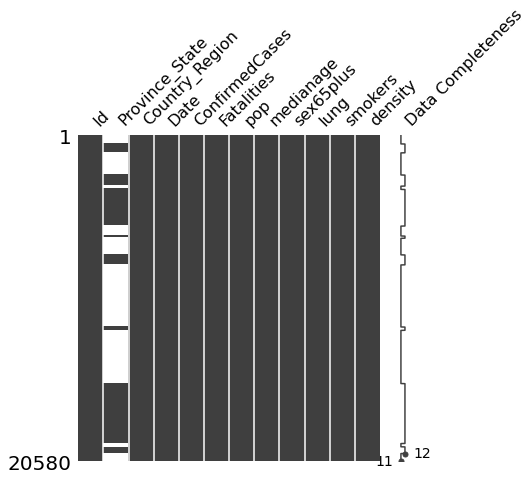

In [14]:
# missing value visualisation
msno.matrix(train, labels=True, figsize=(6, 6))
# below diagram shows that "Province_State"has many missing values

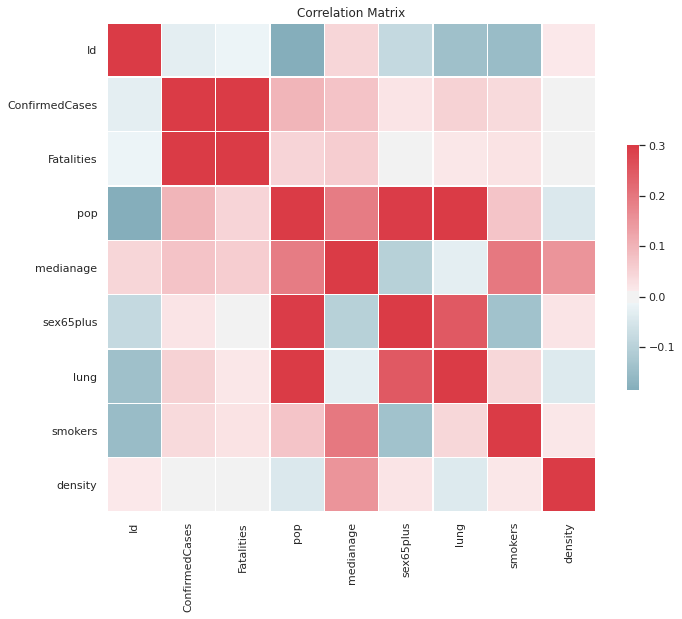

In [15]:
# plot feature importance
sns.set(style="white")
corr = train.corr()
# set up figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})
plt.title("Correlation Matrix")
plt.show()
# below diagram shows that all features are more or less relevant to the label.

## **Preprocessing** ##

In [0]:
# change "Date" format and set index
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
train = train.set_index(['Date'])
test = test.set_index(['Date'])

In [0]:
# create time series features from datetime index
# Reference: https://www.kaggle.com/resheto/covid-19-prediction-of-deltas-using-extended-data/output
def create_time_features(df):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[[
        'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
        'dayofmonth', 'weekofyear'
    ]]
    return X

In [18]:
create_time_features(train).head()
create_time_features(test).head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2020-03-19,0,3,1,3,2020,79,19,12
2020-03-20,0,4,1,3,2020,80,20,12
2020-03-21,0,5,1,3,2020,81,21,12
2020-03-22,0,6,1,3,2020,82,22,12
2020-03-23,0,0,1,3,2020,83,23,13


In [19]:
# check feature importance
confirmed_corr = train.corr()['ConfirmedCases']
confirmed_corr.sort_values(ascending=False)
#below matrix shows "hour" ,"quarter" and "year" are either null values or same values

ConfirmedCases    1.000000
Fatalities        0.874035
dayofyear         0.114872
weekofyear        0.114539
pop               0.097579
month             0.086171
medianage         0.076326
dayofmonth        0.059037
lung              0.053900
smokers           0.039109
sex65plus         0.022442
dayofweek        -0.005113
density          -0.006398
Id               -0.028293
hour                   NaN
quarter                NaN
year                   NaN
Name: ConfirmedCases, dtype: float64

In [0]:
# drop useless colums
train.drop(columns=[
    "date", "dayofweek", "hour", "quarter", "year", "Province_State", "Id"
],
           axis=1,
           inplace=True)
test.drop(columns=[
    "date", "dayofweek", "hour", "quarter", "year", "Province_State",
    "ForecastId"
],
          axis=1,
          inplace=True)

In [21]:
train.head()
# now there is only one categorical feature ("Country_Region")

,Country_Region,ConfirmedCases,Fatalities,pop,medianage,sex65plus,lung,smokers,density,month,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,
2020-01-22,Afghanistan,0.0,0.0,38928346,18.0,0.85,37.62,24.0,60.0,1,22,22,4
2020-01-23,Afghanistan,0.0,0.0,38928346,18.0,0.85,37.62,24.0,60.0,1,23,23,4
2020-01-24,Afghanistan,0.0,0.0,38928346,18.0,0.85,37.62,24.0,60.0,1,24,24,4
2020-01-25,Afghanistan,0.0,0.0,38928346,18.0,0.85,37.62,24.0,60.0,1,25,25,4
2020-01-26,Afghanistan,0.0,0.0,38928346,18.0,0.85,37.62,24.0,60.0,1,26,26,4


## Encode ##


In [0]:
# encode categorical feature
le = LabelEncoder()


def labelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df

In [0]:
train = labelEncoder(train)
test = labelEncoder(test)

In [0]:
# split label and features
x_train = train[[
    'Country_Region', 'pop', 'medianage', 'sex65plus', 'lung', 'smokers',
    'density', 'month', 'dayofyear', 'dayofmonth', 'weekofyear'
]]
y1 = train[['ConfirmedCases']]
y2 = train[['Fatalities']]
x_test = test[[
    'Country_Region', 'pop', 'medianage', 'sex65plus', 'lung', 'smokers',
    'density', 'month', 'dayofyear', 'dayofmonth', 'weekofyear'
]]

## **Model Comparison** ##

In [25]:
# use cross validation to compare models' performace
models = [
    LinearRegression(),
    xgboost.XGBRegressor(objective='reg:squarederror'),
    RandomForestRegressor(),
    ElasticNet()
]
models_name = [
    "LinearRegression", "XGBoost", "RandomForestRegressor", "ElasticNet"
]
score_list = []
X_train, X_test, y_train, y_test = train_test_split(x_train,
                                                    y1,
                                                    test_size=0.4,
                                                    random_state=0)

# see each model's performance
for index, model in enumerate(models):
    print('current model：{}'.format(models_name[index]), end=",")
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring="neg_mean_squared_error")
    print("cross validation RMSE: ", np.sqrt((-1) * scores).mean())
    score_list.append(np.sqrt((-1) * scores).mean())
print("the best model：", models_name[np.argmin(score_list)])

current model：LinearRegression,cross validation RMSE:  4308.859023106878
current model：XGBoost,cross validation RMSE:  3497.4999765342427
current model：RandomForestRegressor,cross validation RMSE:  3574.7194666664022
current model：ElasticNet,cross validation RMSE:  4307.912925575243
the best model： XGBoost


## **Fine Tune** ##

In [26]:
# use a grid search to find appropriate parameters
model = xgboost.XGBRegressor(random_state=42)
learning_rate_grid = [0.2, 0.3, 0.5]
n_estimators_grid = [100, 200, 250]
max_depth_grid = [2, 4, 6]
param_grid = dict(learning_rate=learning_rate_grid,
                  max_depth=max_depth_grid,
                  n_estimators=n_estimators_grid)

grid_search = GridSearchCV(model,
                           param_grid,
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1,
                           cv=3,
                           verbose=0)
grid_result = grid_search.fit(x_train, y1)
print("Best for y: %f using %s" %
      (grid_result.best_score_, grid_result.best_params_))

[10:24:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best for y: -4244.056668 using {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}


## **Train** ##

In [27]:
model = xgboost.XGBRegressor(
    learning_rate=grid_result.best_params_['learning_rate'],
    n_estimators=grid_result.best_params_['n_estimators'],
    max_depth=grid_result.best_params_['max_depth'],
    num_parallel_tree=1,
    objective='reg:squarederror')
model.fit(x_train, y1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

## **Feature and Model Assessment** ##

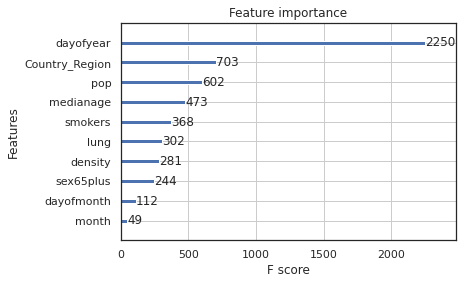

In [28]:
# plot the feature importance
plot = plot_importance(model, height=0.2)
# below diagram shows "dayofyear" is the most important feature

In [0]:
# plot a learning curve to see: whether the model performs better with increasing training values & if the model is suffering from over- or under-fitting
# reference: Geron,A.(2019).Hands-on Machine Learning with Scikit-Learn,Keras and TensorFlow.O'reilly.
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []

    # Create training and test scores for various training set sizes
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)

        # store training and validation erros
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    # plot set up
    plt.figure(figsize=(14, 5))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.legend(loc="upper right")
    plt.title("Learning Curve")

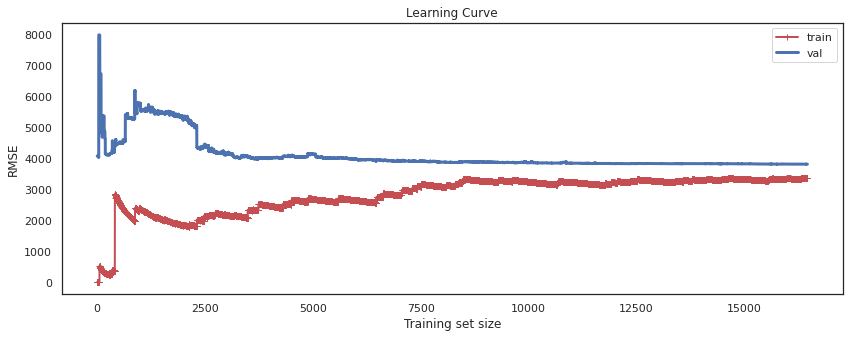

In [30]:
plot_learning_curves(model, x_train, y1)
# below diagram shows the model is roughly balanced

## **Predict and Save the file** ##

In [0]:
# predict confirmed cases
model.fit(x_train, y1)
prediction1 = model.predict(x_test)
prediction1 = pd.DataFrame(prediction1)
prediction1.columns = ["ConfirmedCases_prediction"]

In [0]:
# predict fatalities
model.fit(x_train, y2)
prediction2 = model.predict(x_test)
prediction2 = pd.DataFrame(prediction2)
prediction2.columns = ["Death_prediction"]

In [0]:
sub_new = test1[["ForecastId"]]
submit = pd.concat([prediction1, prediction2, sub_new], axis=1)
submit.columns = ['ConfirmedCases', 'Fatalities', 'ForecastId']
submit = submit[['ForecastId', 'ConfirmedCases', 'Fatalities']]

In [41]:
# Final submission
submit.head(5)

,ForecastId,ConfirmedCases,Fatalities
0,1,30.995928,1.568843
1,2,48.992489,-0.621636
2,3,34.242706,1.740240
3,4,45.026318,1.508695
4,5,58.427799,2.088920


In [0]:
submit.to_csv("submission_final.csv", index=False)

In [0]:
from google.colab import files
files.download("submission_final.csv")